In [ ]:
!pip install ultralytics
!pip install -U ipywidgets

In [60]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import cv2
import os
import xml.etree.ElementTree as et
import seaborn as sns
import shutil
from PIL import Image as pilim, ImageDraw, ImageFont
from distutils.dir_util import copy_tree
#from IPython.display import Image
from torchvision.utils import save_image
from time import time
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from IPython.display import FileLink
from torch import tensor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [3]:
#images_dir = '/kaggle/input/face-mask-detection/images'
#annotations_dir = '/kaggle/input/face-mask-detection/annotations'
#out_dir = '/kaggle/working/'
# adding extra images to enrich the class 'mask_worn_incorrectly'
#images_dir_incorr = '/kaggle/input/face-mask-detection-add-incorr/incorr_mask_add/images'
#annotations_dir_incorr = '/kaggle/input/face-mask-detection-add-incorr/incorr_mask_add/annotations'

path_to_project = '/home/ss/Documents/ds/git/MedMask_detection/'
images_dir = path_to_project + 'data/images/'
annotations_dir = path_to_project + 'data/annotations/'
# adding extra images to enrich the class 'mask_worn_incorrectly'
images_dir_add = path_to_project + 'data/incorr_mask_add/images'
annotations_dir_add = path_to_project + 'data/incorr_mask_add/annotations'

In [147]:
class FaceMaskDataset(torch.utils.data.Dataset):
    """ Build dataset """
    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.anns = [ann for ann in sorted(os.listdir(annotation_dir))]
        self.classes = {'bg':[0,'bg'], 'without_mask': [1,'NO'],'with_mask': [2,'WITH'],'mask_weared_incorrect': [3,'INCORR']}
        
        # removing a file causing libpng warning
        if 'maksssksksss230.png' in self.imgs:
            self.imgs.remove('maksssksksss230.png')
            self.anns.remove('maksssksksss230.xml')
            
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)
        # change color & size
        img = cv2.imread(image_path) #HWC
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # normalization
        img_res /= 255.0
        # annotation
        annot_filename = self.anns[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        wt = img.shape[1]
        ht = img.shape[0]

        # bounding boxes
        for member in root.findall('object'):
            labels.append(self.classes[member.find('name').text][0])
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            # correction for anomalies when xmax > width or ymax > height
            if xmax_corr > self.width:
                xmax_corr = self.width
            if ymax_corr > self.height:
                ymax_corr = self.height
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        # bboxes to torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = dict()
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        if self.transforms:
            sample = self.transforms(image = img_res, bboxes = target['boxes'], labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target, img_name

    def __len__(self):
        return len(self.imgs)

    
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224)
print('Dataset length:', len(dataset))

Dataset length: 852


In [148]:
def plot_image(img_tensor, box_source, titles = ['title1', 'title2', 'title3'], show_score=[False, False, False]):
    """ Visualization of image with bboxes """
    num = len(box_source)
    fig, a = plt.subplots(1, num, figsize=(num*6,7))
    if num==1:
        a = np.array([a])
    img = img_tensor#.data
    mask_dic = {0:['bg', 'white'], 1:['NO', 'red'], 2:['WITH', 'green'], 3:['INCORR', 'orange']}

    for (n, source), title, pred in zip(enumerate(box_source), titles, show_score):
        a[n].imshow(img.permute(1, 2, 0))
    
        for i,box in enumerate(source["boxes"]):
            xmin, ymin, xmax, ymax = box

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor=mask_dic[int(source['labels'][i].data)][1],facecolor='none')

            a[n].add_patch(rect)
            label = mask_dic[int(source['labels'][i].data)][0]
            if pred:
                score = int((source['scores'][i].data) * 100)
                a[n].text(xmin, ymin, f"{label} : {score}%", horizontalalignment='center', verticalalignment='center',fontsize=10,color='red')
                a[n].set_title(title)
            else:
                score=''
                a[n].text(xmin, ymin, f"{label}", horizontalalignment='center', verticalalignment='center',fontsize=10,color='red')
                a[n].set_title(title)
    plt.show()


(224, 224, 3)
{'boxes': tensor([[  1.1200,  27.8756,  10.6400,  45.7956],
        [ 12.8800,  35.8400,  25.2000,  58.7378],
        [ 16.8000,  70.6844,  28.5600,  91.5911],
        [  2.2400, 176.2133,  19.6000, 208.0711],
        [ 52.0800,  14.9333,  65.5200,  33.8489],
        [ 55.4400,  73.6711,  68.3200,  99.5556],
        [ 31.3600, 131.4133,  44.2400, 161.2800],
        [ 20.1600, 151.3244,  36.4000, 182.1867],
        [ 77.2800, 190.1511,  92.4000, 220.0178],
        [101.9200,  12.9422, 117.0400,  35.8400],
        [105.2800,  54.7556, 119.2800,  79.6444],
        [109.7600, 145.3511, 122.6400, 167.2533],
        [119.2800, 163.2711, 136.0800, 192.1422],
        [141.6800,  12.9422, 155.1200,  34.8444],
        [137.7600,  72.6756, 150.0800,  97.5644],
        [160.1600,   9.9556, 175.8400,  37.8311],
        [179.2000,   0.9956, 190.9600,  14.9333],
        [193.2000,  33.8489, 208.3200,  56.7467],
        [200.4800, 115.4844, 217.2800, 140.3733]]), 'labels': tensor([2, 2, 

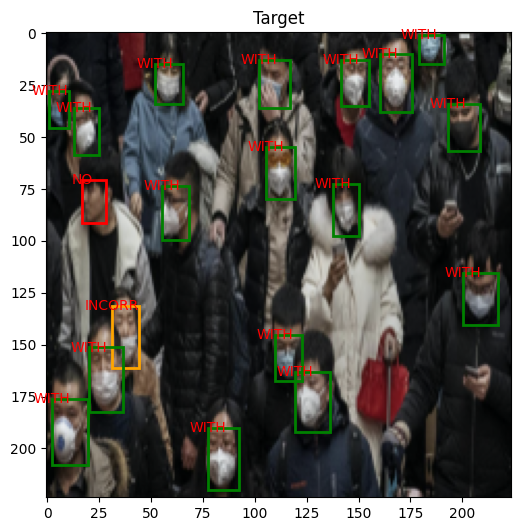

In [160]:
img, target, _ = dataset[45]

print(img.shape)
print(target)
plot_image(torch.tensor(img).permute(2,0,1), [target], ['Target'], [False]);

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))


def get_transform(train):    
    """ Apply albumentations """
    if train:
        return A.Compose([#A.HorizontalFlip(0.5),
                          #A.RandomBrightnessContrast(p=0.5),
                          #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=0.3),
                          #A.Blur(blur_limit=3,p=1),
                          #A.RandomFog(p=1), 
                          #A.RandomBrightness(p=1), 
                          #A.RandomCrop(p=1,height = 200, width = 200), 
                          #A.Rotate(p=0.5, limit=20),
                          #A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=1), 
                          #A.RandomSnow(p=1), 
                          #A.VerticalFlip(p=1), 
                          #A.RandomContrast(limit = 0.5,p = 1),
                          ToTensorV2(p=1.0) 
                          ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}) # min_visibility=0.3
    else:
        return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    

In [8]:
dataset = FaceMaskDataset(images_dir, annotations_dir, 640, 640, transforms= get_transform(train=True))
dataset_add = FaceMaskDataset(images_dir_add, annotations_dir_add, 640, 640, transforms= get_transform(train=False))
dataset_expanded = torch.utils.data.ConcatDataset([dataset, dataset_add])

# divide data to train and valid subsets
torch.manual_seed(1)
indices = torch.randperm(len(dataset_expanded)).tolist()

test_split = 0.2
tsize = int(len(dataset_expanded)*test_split)
dataset_train = torch.utils.data.Subset(dataset_expanded, indices[:-tsize])
dataset_valid = torch.utils.data.Subset(dataset_expanded, indices[-tsize:])

# dataloaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=collate_fn)
data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

print(f"Main dataset: {len(dataset)}, incorrect add: {len(dataset_add)}, expanded dataset: {len(dataset_expanded)}")
print(f"TRAIN: {len(dataset_train)}, VALID: {len(dataset_valid)}")

Main dataset: 852, incorrect add: 105, expanded dataset: 957
TRAIN: 766, VALID: 191


In [9]:
class_decoder = dataset.__dict__['classes']
class_decoder

{'bg': [0, 'bg'],
 'without_mask': [1, 'NO'],
 'with_mask': [2, 'WITH'],
 'mask_weared_incorrect': [3, 'INCORR']}

In [10]:
def class_counter(data):
    """ Count class instances"""
    cl_counter = Counter()
    for n, (im, an, _) in enumerate(data):
        #print(n)
        cl_counter += Counter(an['labels'].numpy())
    return cl_counter

print(f"Class instances in dataset: {class_counter(dataset)}")
print(f"Class instances in add: {class_counter(dataset_add)}")
print(f"Class instances in train: {class_counter(dataset_train)}")
print(f"Class instances in valid: {class_counter(dataset_valid)}")

Class instances in dataset: Counter({2: 3227, 1: 717, 3: 123})
Class instances in add: Counter({3: 141, 2: 98, 1: 32})
Class instances in train: Counter({2: 2730, 1: 590, 3: 207})
Class instances in valid: Counter({2: 595, 1: 159, 3: 57})


    Classes are imbalanced. The purpose of 'add'-dataset is to correct this situation and enrich the data with less represented class instances 

In [11]:
print(f"Batches in train: {len(data_loader_train)}")
print(f"Batches in valid: {len(data_loader_valid)}")

Batches in train: 77
Batches in valid: 20


## FasterRCNN

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4

In [13]:
def get_model_instance_detection(num_classes):
    """ return fasterrcnn_resnet50_fpn_v2 with FastRCNNPredictor for num_classes """
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    #for param in model.parameters():
    #    param.requires_grad = True
    #for param in model.roi_heads.parameters():
    #    param.requires_grad = True
            
    return model

In [14]:
start_time = time()
model = get_model_instance_detection(num_classes)
num_epochs = 50
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.005, weight_decay=0.0005)
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for imgs, annotations, _ in data_loader_train:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    print(epoch, 'Epoch_loss = ',epoch_loss)

frcnn_time = time() - start_time
print(f"Training time {frcnn_time}")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 197MB/s]  


0 Epoch_loss =  43.68647912144661
1 Epoch_loss =  23.591002628207207
2 Epoch_loss =  18.33119310438633
3 Epoch_loss =  15.593068584799767
4 Epoch_loss =  14.215482167899609
5 Epoch_loss =  12.803005680441856
6 Epoch_loss =  11.36477367579937
7 Epoch_loss =  10.46034736186266
8 Epoch_loss =  9.64181935787201
9 Epoch_loss =  9.193651489913464
10 Epoch_loss =  8.423665091395378
11 Epoch_loss =  8.048314698040485
12 Epoch_loss =  7.517088793218136
13 Epoch_loss =  6.844099931418896
14 Epoch_loss =  6.478018756955862
15 Epoch_loss =  6.186168313026428
16 Epoch_loss =  6.125532161444426
17 Epoch_loss =  5.605775386095047
18 Epoch_loss =  5.361617986112833
19 Epoch_loss =  5.136809144169092
20 Epoch_loss =  4.748076379299164
21 Epoch_loss =  4.705041076987982
22 Epoch_loss =  4.407481286674738
23 Epoch_loss =  4.455298533663154
24 Epoch_loss =  4.495748728513718
25 Epoch_loss =  4.09061429835856
26 Epoch_loss =  3.991619948297739
27 Epoch_loss =  3.8448910266160965
28 Epoch_loss =  3.78794778

In [20]:
# saving model weights
torch.save(model.state_dict(), '/kaggle/working/fasterrcnn.pt')
!zip -r /kaggle/working/fasterrcnn_50_eps.zip /kaggle/working/fasterrcnn.pt

  adding: kaggle/working/fasterrcnn.pt (deflated 7%)


In [22]:
# download the model weights
os.chdir(out_dir)

FileLink(r'fasterrcnn_50_eps.zip')

/kaggle/working/fasterrcnn_50_eps.zip

In [17]:
device = torch.device('cpu')
frcnn = get_model_instance_detection(num_classes)
frcnn.load_state_dict(torch.load(path_to_project + 'data/import/fasterrcnn.pt', map_location=device))#torch.device('cpu')))
frcnn.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

### **Prediction visualization**

### NMS
Performs non-maximum suppression (NMS) on the boxes according to their intersection-over-union (IoU).

NMS iteratively removes lower scoring boxes which have an IoU greater than iou_threshold with another (higher scoring) box.

If multiple boxes have the exact same score and satisfy the IoU criterion with respect to a reference box, the selected box is not guaranteed to be the same between CPU and GPU. This is similar to the behavior of argsort in PyTorch when repeated values are present.

In [161]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    """ Apply Non Maximum Suppression to a model prediction """
    
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

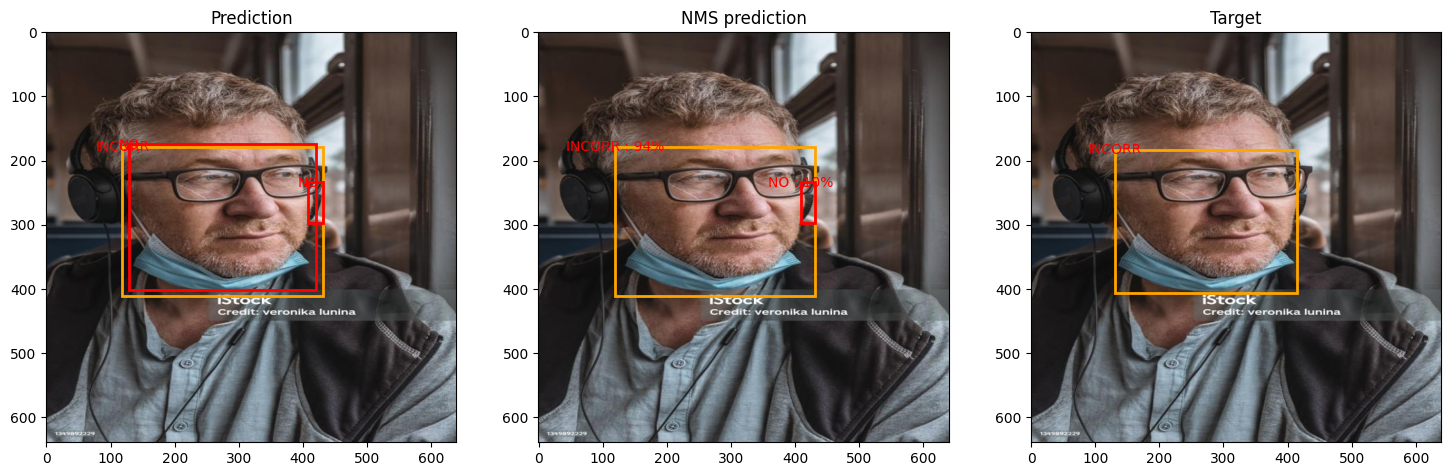

In [238]:
# let's visualize how NMS works
img, target, _ = dataset_valid[22]

frcnn.eval()
with torch.no_grad():
    prediction = frcnn([img.to(device)])[0]

plot_image(img, 
           [prediction, apply_nms(prediction.copy(), iou_thresh=0.2), target], 
           ['Prediction', 'NMS prediction', 'Target'], 
           [False, True, False]
           )

NMS can be useful from the point of view of the metrics computed, particularly when there are several predicted boxes of one class for the same class instance. By default it's off in YOLO. 

In [239]:
# visualization of the model predictions

random_batch = np.random.choice(len(data_loader_valid),1,replace=False)
print(f"Random batch: {random_batch[0]}")

for n, (imgs, annotations, _) in enumerate(data_loader_valid):
    if n == random_batch[0]:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        frcnn.eval()
        with torch.no_grad():
            preds = frcnn(imgs)        
        break

Random batch: 6


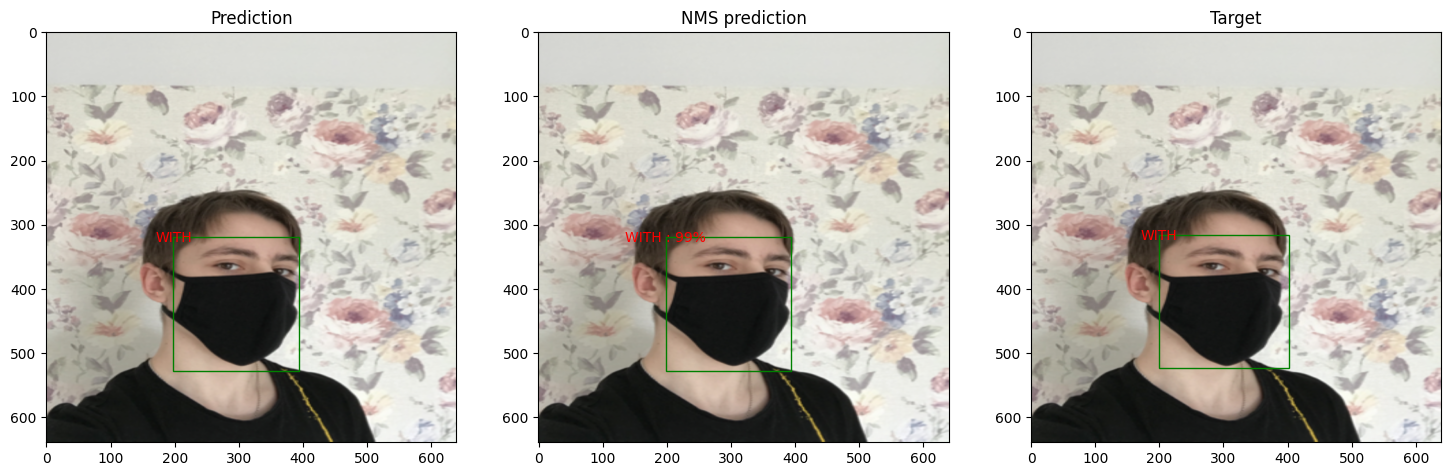

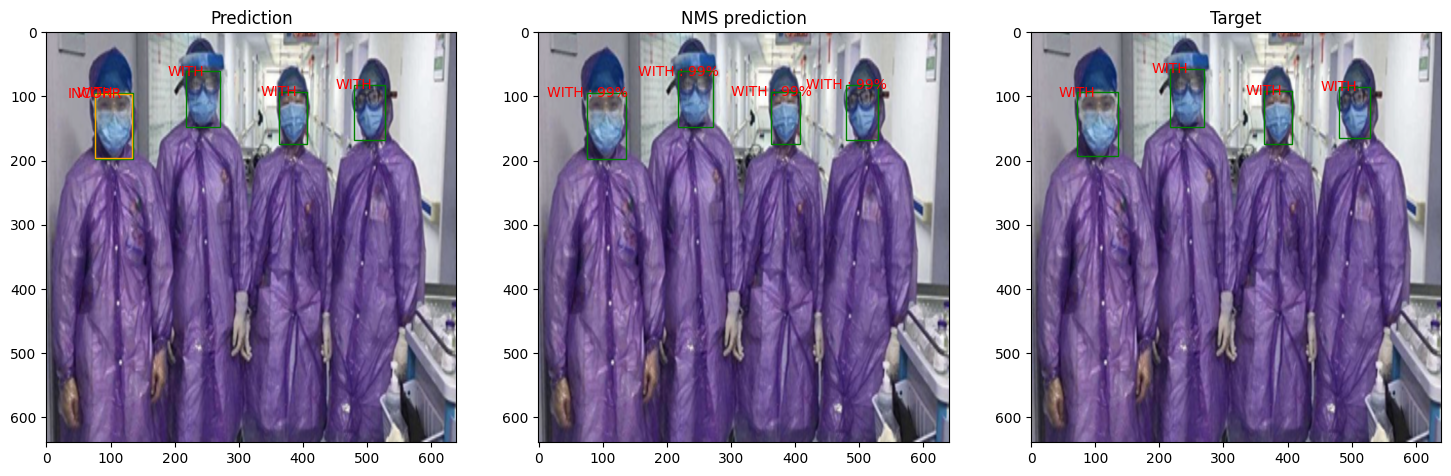

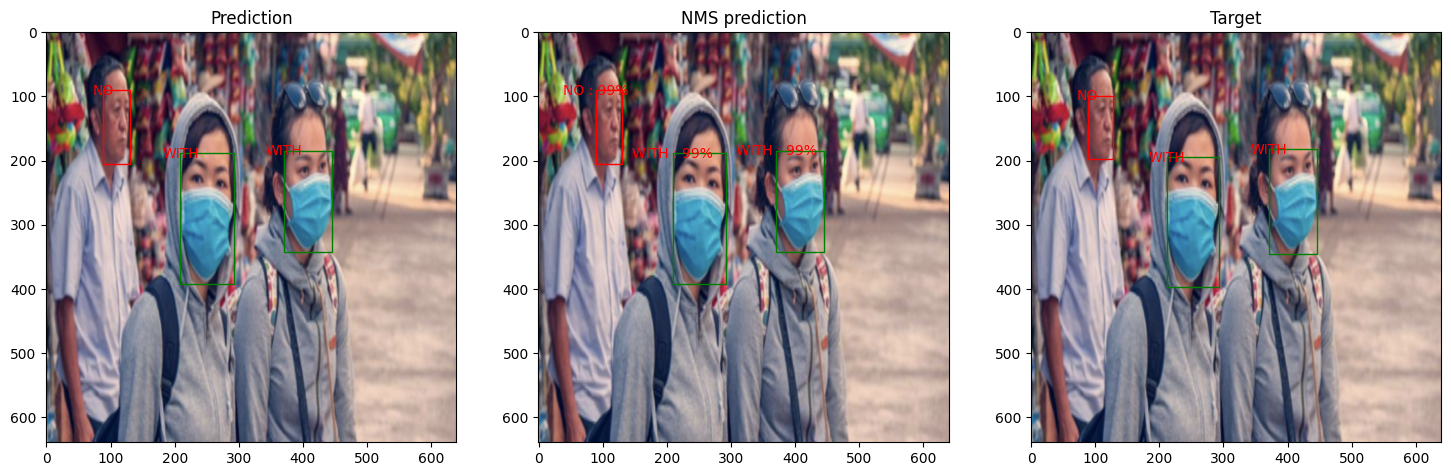

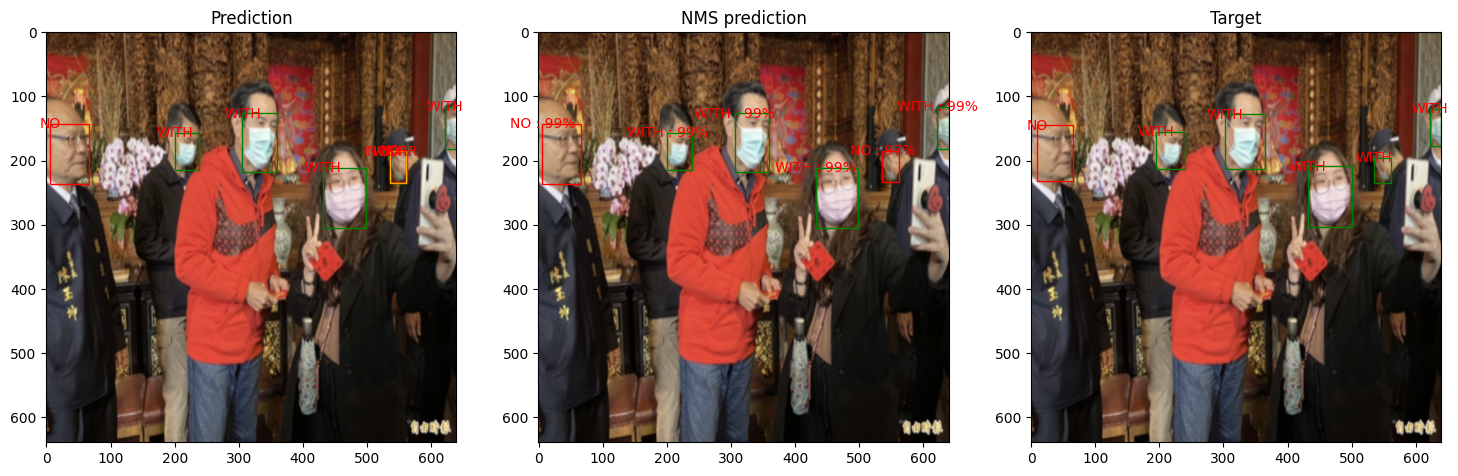

In [144]:
for i in np.random.choice(10,3,replace=False):
    nms_prediction = apply_nms(preds[i].copy(), iou_thresh=0.2)

    plot_image(
        imgs[i], 
        [preds[i], nms_prediction, annotations[i]], 
        ['Prediction', 'NMS prediction', 'Target'], 
        [False, True, False])

### **Model evaluation**

In [55]:
def get_AP(precision, recall):
    """ Compute AP """
    AP = 0
    max_precision = 0
    prev_recall = 0
    
    # Calculating AP
    for i in range(len(recall)):
        if precision[i] > max_precision:
            max_precision = precision[i]
        AP += max_precision * (recall[i] - prev_recall)
        prev_recall = recall[i]

    return AP

In [56]:
def get_score_df(df, annotation, prediction, threshold, yolov=False):
    """ Define if predicted boxes are TP or FP depending on the threshold

    Args:
        df (dataframe): source DF to concatenate new data with
        annotation (dict): target 
        prediction (transformed to dict): model prediction
        threshold (float): _description_
        yolov (int): yolo version. Defaults to False.

    Returns:
        Dataframe: concatenated DF
    """
    if yolov==5:
        prediction_df = prediction.pandas().xyxy[0]
        if len(prediction_df)==0:
            return df
        prediction = dict()
        prediction['boxes'] = torch.tensor(prediction_df[['xmin', 'ymin', 'xmax', 'ymax']].values)
        prediction['scores'] = torch.tensor(prediction_df['confidence'].values)
        prediction['labels'] = torch.tensor(prediction_df['class'].values).type(torch.int32)
        print(prediction)
    elif yolov==8:
        pred_dict = dict()
        pred_dict['boxes'] = prediction[0].boxes.xyxy
        pred_dict['scores'] = prediction[0].boxes.conf
        pred_dict['labels'] = prediction[0].boxes.cls
        prediction = pred_dict
        
    for label in set(list(prediction['labels'].numpy())):
        
        targ = annotation['labels'].numpy()
        pred = prediction['labels'].numpy()
        ids_targ = np.asarray(targ==label).nonzero()
        ids_pred = np.asarray(pred==label).nonzero()

        m = torchvision.ops.complete_box_iou(
            annotation['boxes'][ids_targ], 
            prediction['boxes'][ids_pred]
            ).numpy()
        
        for n,item in enumerate(pred[ids_pred]):        
            entry = {'TP': [0], 'FP': [0], 'label': int(label), 'threshold': threshold, 'GT': len(ids_targ[0])}
            entry['score'] = prediction['scores'][ids_pred][n].item()
            entry['id'] = str(annotation['image_id'].item())
            
            try:
                iou = m[:,n][np.argmax(m[:,n])]
            except:
                iou = 0
            entry['iou'] = iou
            if iou > threshold and iou == np.max(m[np.argmax(m[:,n])]):
                entry['TP'] = [1]
            else:
                entry['FP'] = [1]
            
            df = pd.concat([df, pd.DataFrame(entry)], ignore_index=True) 
                
    return df 

In [57]:
def get_metrics(data, cl_decoder):
    """ count AP per class

    Args:
        data (dataframe): dataframe with source data per prediction: IOU, bool for TP or FP
        cl_decoder (_type_): connect class index with class name

    Returns:
        dict: AP50 value per class as key
    """
    
    classes_unique = sorted(data['label'].unique())
    f,a = plt.subplots(1,len(classes_unique),figsize=(len(classes_unique)*5,5))
    AP50 = dict()
    
    for n,label in enumerate(classes_unique):
        aps = []
        for threshold in [0.5, 0.75, 0.95]:
            dfs = data[(data['threshold']==threshold) & (data['label']==label)].sort_values(['score'], ascending=False)
            dfs['cum TP'] = dfs['TP'].cumsum()
            dfs['cum FP'] = dfs['FP'].cumsum()
            dfs['precision'] = dfs['cum TP'] / (dfs['cum TP'] + dfs['cum FP'])
            GT = dfs.groupby('id')['GT'].mean().sum()
            dfs['recall'] = dfs['cum TP'] / GT

            AP = get_AP(dfs['precision'].values, dfs['recall'].values)

            sns.lineplot(data=dfs, x='recall', y='precision', label = f"IoU={threshold}/AP={round(AP,3)}", ax=a[n], errorbar=None).set(
                xlabel='Recall',
                ylabel='Precision',
                title=f'PR Curve. Class#{label}: {cl_decoder[label]}')
            a[n].legend(loc='lower center')

            aps.append(round(AP,3))
        AP50[label] = aps[0]
    plt.show()

    return AP50

In [119]:
thresholds = [0.5, 0.75, 0.95] 
df = pd.DataFrame()

frcnn.eval()
with torch.no_grad():
    metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5], extended_summary=False, class_metrics=True)
    for ims, ans, _ in data_loader_valid:
        ims = list(image.to(device) for image in ims)
        ans = [{k: v.to(device) for k, v in a.items()} for a in ans]

        for t,p in zip(ans, frcnn(ims)):
        #for t,p in zip(ans, [apply_nms(i) for i in model(ims)]):
            metric.update([p], [t])
            for threshold in thresholds: 
                df = get_score_df(df, t, p, threshold)

    metric_res = metric.compute()
    metric.reset()
    print(metric_res)
    

frcnn_AP50_torch = metric_res['map_per_class']
frcnn_mAP50_torch = metric_res['map_50'].item()

#print(f'AP50 in classes:{frcnn_AP50_torch}')
#print(f"mAP50: {round(frcnn_mAP50_torch,3)}")

print(f"Metric DF shape: {df.shape}")
df.head().style.set_properties(subset=df.columns, **{'width': '50px', 'text-align': 'right'})


{'map': tensor(0.8378), 'map_50': tensor(0.8378), 'map_75': tensor(-1.), 'map_small': tensor(0.6705), 'map_medium': tensor(0.9124), 'map_large': tensor(0.9525), 'mar_1': tensor(0.4177), 'mar_10': tensor(0.8112), 'mar_100': tensor(0.8712), 'mar_small': tensor(0.7463), 'mar_medium': tensor(0.9310), 'mar_large': tensor(0.9586), 'map_per_class': tensor([0.7704, 0.9164, 0.8265]), 'mar_100_per_class': tensor([0.8302, 0.9412, 0.8421]), 'classes': tensor([1, 2, 3], dtype=torch.int32)}
Metric DF shape: (2928, 8)


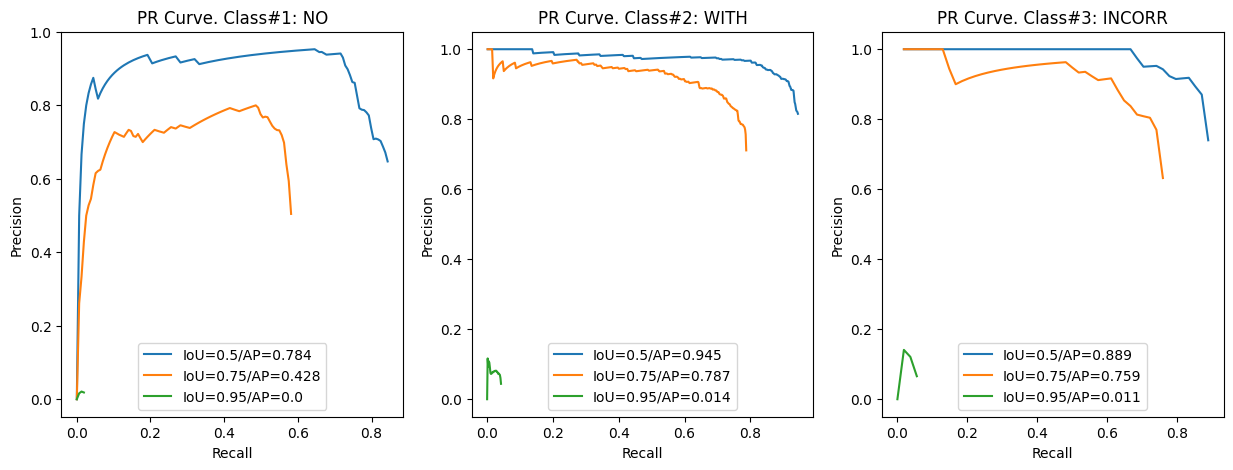

AP50 in classes: {1: 0.784, 2: 0.945, 3: 0.889}
mAP50: 0.873


In [120]:
classes = dataset.__dict__['classes']
class_decoder = dict((x[0],x[1]) for x in classes.values())

# compute mAP from scratch
frcnn_AP50_scratch = get_metrics(df, class_decoder)
frcnn_mAP50_scratch = np.mean(list(frcnn_AP50_scratch.values())).round(3)

print(f'AP50 in classes: {frcnn_AP50_scratch}')
print(f"mAP50: {frcnn_mAP50_scratch}")

In [77]:
print('average IOU in classes:')
display(df[(df['threshold']==0.5)].groupby('label')['iou'].mean())
print('MEAN IOU:', df[(df['threshold']==0.5)].groupby('label')['iou'].mean().mean().round(2))

average IOU in classes:


label
1    0.388976
2    0.623308
3    0.487939
Name: iou, dtype: float64

MEAN IOU: 0.5


## **YOLO v8s**

In [78]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

path_to_yolo = '/home/ss/Documents/ds/git/SF_2/yolov5/'
out_dir = path_to_yolo + 'data/'

In [79]:
# arrange folders for datasets
for i in ["train", "valid"]:
    if not os.path.exists(out_dir + i):
        os.mkdir(out_dir + i)
    else:
        shutil.rmtree((out_dir + i))
        os.mkdir(out_dir + i)
    os.mkdir(out_dir + i + '/images')
    os.mkdir(out_dir + i + '/labels')

In [80]:
def convert_to_yolo(data_loader, tofolder='train'):
    """ convert annotations to yolo format, copy images&annotation to arranged folders """
    img_objects = dict()

    for ims, ans, names in data_loader:
        for n, (im,an,name) in enumerate(zip(ims,ans, names)):
            name = name.replace('.jpg','.png')
            img_objects[name] = []

            for num in range(len(an['boxes'])):
                box = an['boxes'][num]
                class_id = an['labels'][num].item()
                X = ((box[0] + box[2]) / 2).item()
                Y = ((box[1] + box[3]) / 2).item()
                Width = (box[2] - box[0]).item()
                Height = (box[3] - box[1]).item()

                # normalization
                img_shape = im.shape
                image_c, image_w, image_h = img_shape[0], img_shape[1], img_shape[2]
                X /= image_w
                Y /= image_h
                Width /= image_w
                Height /= image_h

                img_objects[name].append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))
            save_image(im, out_dir + f"{tofolder}/images/{name}")
    
    for key in img_objects.keys():
        save_file_name = os.path.join(out_dir + f"{tofolder}/labels/", key.replace(".png",".txt"))
        print("\n".join(img_objects[key]), file = open(save_file_name, "w"))


convert_to_yolo(data_loader_train, 'train')
convert_to_yolo(data_loader_valid, 'valid')

In [81]:
for i in ['train', 'valid']:
    print(f"{i.upper()} images: {len(os.listdir(out_dir + f'{i}/images'))}")
    print(f"{i.upper()} annotations: {len(os.listdir(out_dir + f'{i}/labels'))}")


TRAIN images: 766
TRAIN annotations: 766
VALID images: 191
VALID annotations: 191


In [82]:
# random visualization
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w,h = image.size
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    #print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    mask_dic = {0:['bg', 'white'], 1:['NO', 'red'], 2:['WITH', 'green'], 3:['INCORR', 'orange']}
    f,a = plt.subplots(figsize=(8,8))
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        print(w,h, obj_cls, x0, y0, x1, y1)
        plotted_image.rectangle(((x0,y0), (x1,y1)), width=2, outline=mask_dic[(int(obj_cls))][1], )
        plotted_image.text((x0, y0 - 10), mask_dic[(int(obj_cls))][0], fill='red')


    plt.imshow(np.array(image))
    plt.show()

random annotation: ['/home/ss/Documents/ds/git/SF_2/yolov5/data/valid/labels/maksssksksss342.txt']
640 640 1.0 44.480000000000004 131.52 86.08000000000001 201.28000000000003
640 640 2.0 137.6 113.91999999999999 164.48 158.72
640 640 2.0 164.8 121.6 185.92000000000002 153.6
640 640 2.0 207.68000000000004 104.32 230.08000000000004 144.0
640 640 2.0 115.52000000000001 230.72 158.4 297.92
640 640 2.0 169.92000000000002 287.68 232.0 392.0
640 640 2.0 243.52 118.72 259.52 148.8
640 640 2.0 256.0 138.88 276.48 173.44
640 640 2.0 294.71999999999997 158.4 324.79999999999995 225.60000000000002
640 640 2.0 340.8 116.47999999999999 361.92 163.83999999999997
640 640 2.0 403.52000000000004 235.52 459.20000000000005 322.56
640 640 2.0 511.68 476.16 616.0 632.32
640 640 2.0 475.2 153.92 511.68 210.88


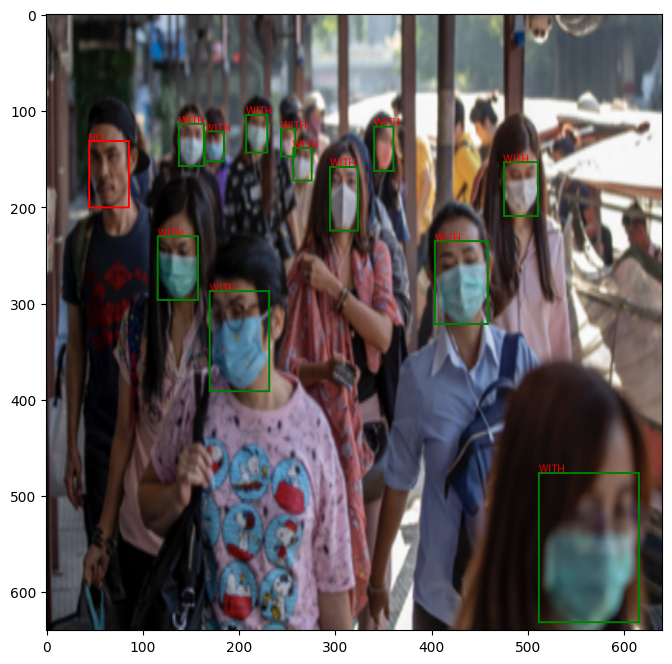

In [84]:
#annotation_random = !ls /kaggle/working/train/labels/*txt | shuf -n 1
annotation_random = !ls /home/ss/Documents/ds/git/SF_2/yolov5/data/valid/labels/*txt | shuf -n 1
s = '2-1024x1024_png.rf.f4f099f97e69efa3623ffb08d0da16f6.txt'
s = 'aq11_png.rf.01afb04345163edd8a4f0ab7763671d2.txt'
#annotation_random = [os.path.join('/kaggle/working/train/labels/',s)]
print(f"random annotation: {annotation_random}")

with open(annotation_random[0], "r") as file:
    ann_list = file.read().split("\n")[:-1]
    ann_list = [x.split(" ") for x in ann_list]
    ann_list = [[float(y) for y in x ] for x in ann_list]
    
# get the corresponding image file
im_file = annotation_random[0].replace("txt", "png").replace("labels", "images")
assert os.path.exists(im_file)

# plot the image
im = pilim.open(im_file)
plot_bounding_box(im, ann_list)

In [85]:
# Create data.yaml file
mask_yaml = f"""
train: {os.path.join(out_dir, 'train/images')}
val: {os.path.join(out_dir, 'valid/images')}
nc: {4}
names: {['bg', 'NO', 'WITH', 'INCORR']}
"""

with open(os.path.join(out_dir, 'mask.yaml'), 'w') as f:
    f.write(mask_yaml)

In [ ]:
#%cd /kaggle
!ls /kaggle/working

In [92]:
start_time = time()

model = YOLO("yolov8s.pt")  # load a pretrained model 

model.train(data=out_dir + "mask.yaml", epochs=50, imgsz=640, batch=32) 
            #workers=4, lr0=0.0001, lrf=0.01, optimizer='AdamW', nms=True, iou=0.7)  # train the model


yolo8s_time = time() - start_time
print(f"Training time {round(yolo8s_time,2)}")


100%|██████████| 21.5M/21.5M [00:00<00:00, 273MB/s]


Ultralytics YOLOv8.2.83 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/mask.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 23.0MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 103MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 766 images, 0 backgrounds, 0 corrupt: 100%|██████████| 766/766 [00:00<00:00, 1079.47it/s]


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/valid/labels... 191 images, 0 backgrounds, 0 corrupt: 100%|██████████| 191/191 [00:00<00:00, 696.06it/s]

val: New cache created: /kaggle/working/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      16.4G      1.861       2.78      1.596        145        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        191        811      0.517      0.421       0.42      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.85G      1.277      1.163      1.123        207        640: 100%|██████████| 24/24 [00:13<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all        191        811      0.493      0.485      0.456      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.83G      1.223     0.9724      1.108        159        640: 100%|██████████| 24/24 [00:13<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all        191        811      0.725      0.553      0.631      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       9.1G      1.247     0.9486      1.105        275        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all        191        811      0.674      0.562      0.629       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.83G      1.211     0.8945      1.108        148        640: 100%|██████████| 24/24 [00:13<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all        191        811      0.679      0.451      0.529      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.84G      1.201     0.8589      1.111        145        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all        191        811      0.753      0.569      0.643      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.83G      1.202     0.8348      1.095        265        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all        191        811      0.797      0.615       0.73      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.84G      1.174     0.7772      1.082        248        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all        191        811      0.893      0.668      0.805      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.83G      1.165     0.7712       1.08        155        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all        191        811      0.816      0.722      0.799      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.83G      1.142      0.741      1.078        219        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all        191        811      0.838       0.75      0.832      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.83G      1.138     0.7152       1.07        153        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all        191        811       0.85      0.721      0.809      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.83G      1.093     0.7011      1.057        182        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all        191        811      0.859      0.705      0.799      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.84G      1.108     0.6933       1.05        219        640: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all        191        811       0.85      0.774      0.828      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.83G      1.112     0.7026      1.049        175        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all        191        811      0.855       0.77       0.84      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.83G      1.111        0.7      1.049        212        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all        191        811      0.857      0.707      0.796      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.83G      1.084     0.6795      1.043        194        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all        191        811      0.872      0.777      0.856      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.83G      1.059     0.6469      1.037        110        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all        191        811       0.85      0.808      0.868      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.83G      1.087     0.6571      1.052        160        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all        191        811       0.85       0.75      0.842       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.83G      1.069      0.638      1.025        192        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all        191        811       0.85      0.812      0.872      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.83G      1.046      0.618      1.026        205        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all        191        811      0.881      0.775      0.868       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.83G      1.043     0.6151      1.018        252        640: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all        191        811      0.852      0.799      0.854      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.83G      1.058     0.6157      1.022        199        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all        191        811      0.891      0.804      0.885      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.83G      1.041     0.5957      1.013        150        640: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all        191        811       0.85      0.821      0.869      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.83G      1.026     0.5915       1.01        269        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all        191        811      0.894      0.798      0.877      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.83G      1.035     0.5881      1.009        166        640: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all        191        811      0.861      0.801      0.872      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.84G      1.006     0.5622      1.008        213        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all        191        811      0.875       0.83      0.896      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.83G     0.9759     0.5365     0.9944        143        640: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all        191        811      0.928      0.772      0.885      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.83G     0.9899      0.552      1.006        129        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all        191        811      0.879      0.802       0.88      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.83G     0.9923     0.5567      1.001        205        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all        191        811      0.863      0.829      0.879      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.83G     0.9719     0.5531      0.996        202        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all        191        811      0.894       0.79      0.879      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.84G     0.9627     0.5282     0.9843        174        640: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all        191        811      0.901      0.799       0.89      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.83G     0.9609      0.531     0.9913        194        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all        191        811      0.896      0.804      0.891      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.83G     0.9679     0.5168      0.982        187        640: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all        191        811      0.862      0.804      0.869      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.83G     0.9635     0.5184     0.9824        215        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all        191        811      0.866      0.839      0.887      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.83G     0.9856     0.5164     0.9809        211        640: 100%|██████████| 24/24 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all        191        811      0.878      0.813      0.892      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.83G     0.9521     0.5086     0.9799        192        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all        191        811      0.893      0.814      0.895      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.83G     0.9554     0.5097     0.9769        206        640: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all        191        811       0.88      0.843      0.908      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.83G       0.93     0.4918     0.9749        227        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all        191        811      0.873      0.815      0.903      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.83G     0.9275     0.4985     0.9694        181        640: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all        191        811      0.894      0.831      0.896      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.83G     0.9088     0.4802     0.9716        208        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all        191        811      0.889      0.842      0.898      0.612


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.83G      0.896     0.4436      0.957        118        640: 100%|██████████| 24/24 [00:15<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all        191        811      0.919      0.808      0.893        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.57G     0.8873     0.4314     0.9518        104        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all        191        811      0.905      0.831      0.906       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.83G     0.8804      0.422     0.9503        121        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all        191        811      0.873      0.853      0.903      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.84G     0.8704     0.4112     0.9438        173        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all        191        811      0.892      0.837      0.905      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.83G     0.8548     0.4072     0.9455        103        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all        191        811       0.91      0.826      0.901      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.83G     0.8592     0.4053     0.9391        103        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all        191        811      0.923      0.814      0.897      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.83G     0.8367     0.3908     0.9389        138        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all        191        811      0.903      0.846      0.904      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.83G     0.8449     0.3968     0.9371        217        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all        191        811      0.897      0.857      0.905      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.84G     0.8203     0.3918     0.9264         96        640: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all        191        811      0.895      0.836      0.907      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.83G     0.8318     0.3876     0.9256        128        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all        191        811      0.906      0.855      0.907      0.618



50 epochs completed in 0.231 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.83 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


                   all        191        811      0.897      0.857      0.904      0.625
                    NO         65        159       0.86      0.775      0.839      0.549
                  WITH        153        595      0.937      0.919      0.956      0.669
                INCORR         39         57      0.894      0.877      0.918      0.656
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/train


Training time 945.75


In [86]:
path_to_run = 'runs/detect/train/'

In [ ]:
#%cd ..
!ls /kaggle/working

In [ ]:
import json
with open(out_dir + "model_train_time_50eps.json", "w") as f:
    json.dump([{"train_time_yolo8s": yolo8s_time, "train_time_fasterrcnn": frcnn_time}], f)

In [96]:
!zip -r /kaggle/working/yolo8s50eps.zip /kaggle/working/runs/detect/train
#%cd ..
!ls

  adding: kaggle/working/runs/detect/train/ (stored 0%)
  adding: kaggle/working/runs/detect/train/results.csv (deflated 85%)
  adding: kaggle/working/runs/detect/train/val_batch0_pred.jpg (deflated 8%)
  adding: kaggle/working/runs/detect/train/weights/ (stored 0%)
  adding: kaggle/working/runs/detect/train/weights/best.pt (deflated 8%)
  adding: kaggle/working/runs/detect/train/weights/last.pt (deflated 8%)
  adding: kaggle/working/runs/detect/train/train_batch962.jpg (deflated 7%)
  adding: kaggle/working/runs/detect/train/val_batch0_labels.jpg (deflated 9%)
  adding: kaggle/working/runs/detect/train/labels_correlogram.jpg (deflated 36%)
  adding: kaggle/working/runs/detect/train/train_batch1.jpg (deflated 2%)
  adding: kaggle/working/runs/detect/train/val_batch1_labels.jpg (deflated 7%)
  adding: kaggle/working/runs/detect/train/results.png (deflated 8%)
  adding: kaggle/working/runs/detect/train/labels.jpg (deflated 27%)
  adding: kaggle/working/runs/detect/train/train_batch960.jp

In [ ]:
!ls /kaggle/working

In [97]:
os.chdir(r'/kaggle/working')
#!zip -r yolo8s09.zip runs/detect/train
#!tar -czf Landscapes.tar.gz images_out/Landscapes
#FileLink(r'Landscapes.tar.gz')
FileLink(r'yolo8s50eps.zip')

/kaggle/working/yolo8s50eps.zip

In [98]:
FileLink(r'model_train_time_50eps.json')

/kaggle/working/model_train_time_50eps.json

In [88]:
def get_yolo(path):
    """ create YOLO instance with saved backend """
    be = plt.get_backend()
    model = YOLO(path)
    matplotlib.use(be)
    return model

In [89]:
yolo = get_yolo(path_to_yolo + path_to_run + 'weights/best.pt')

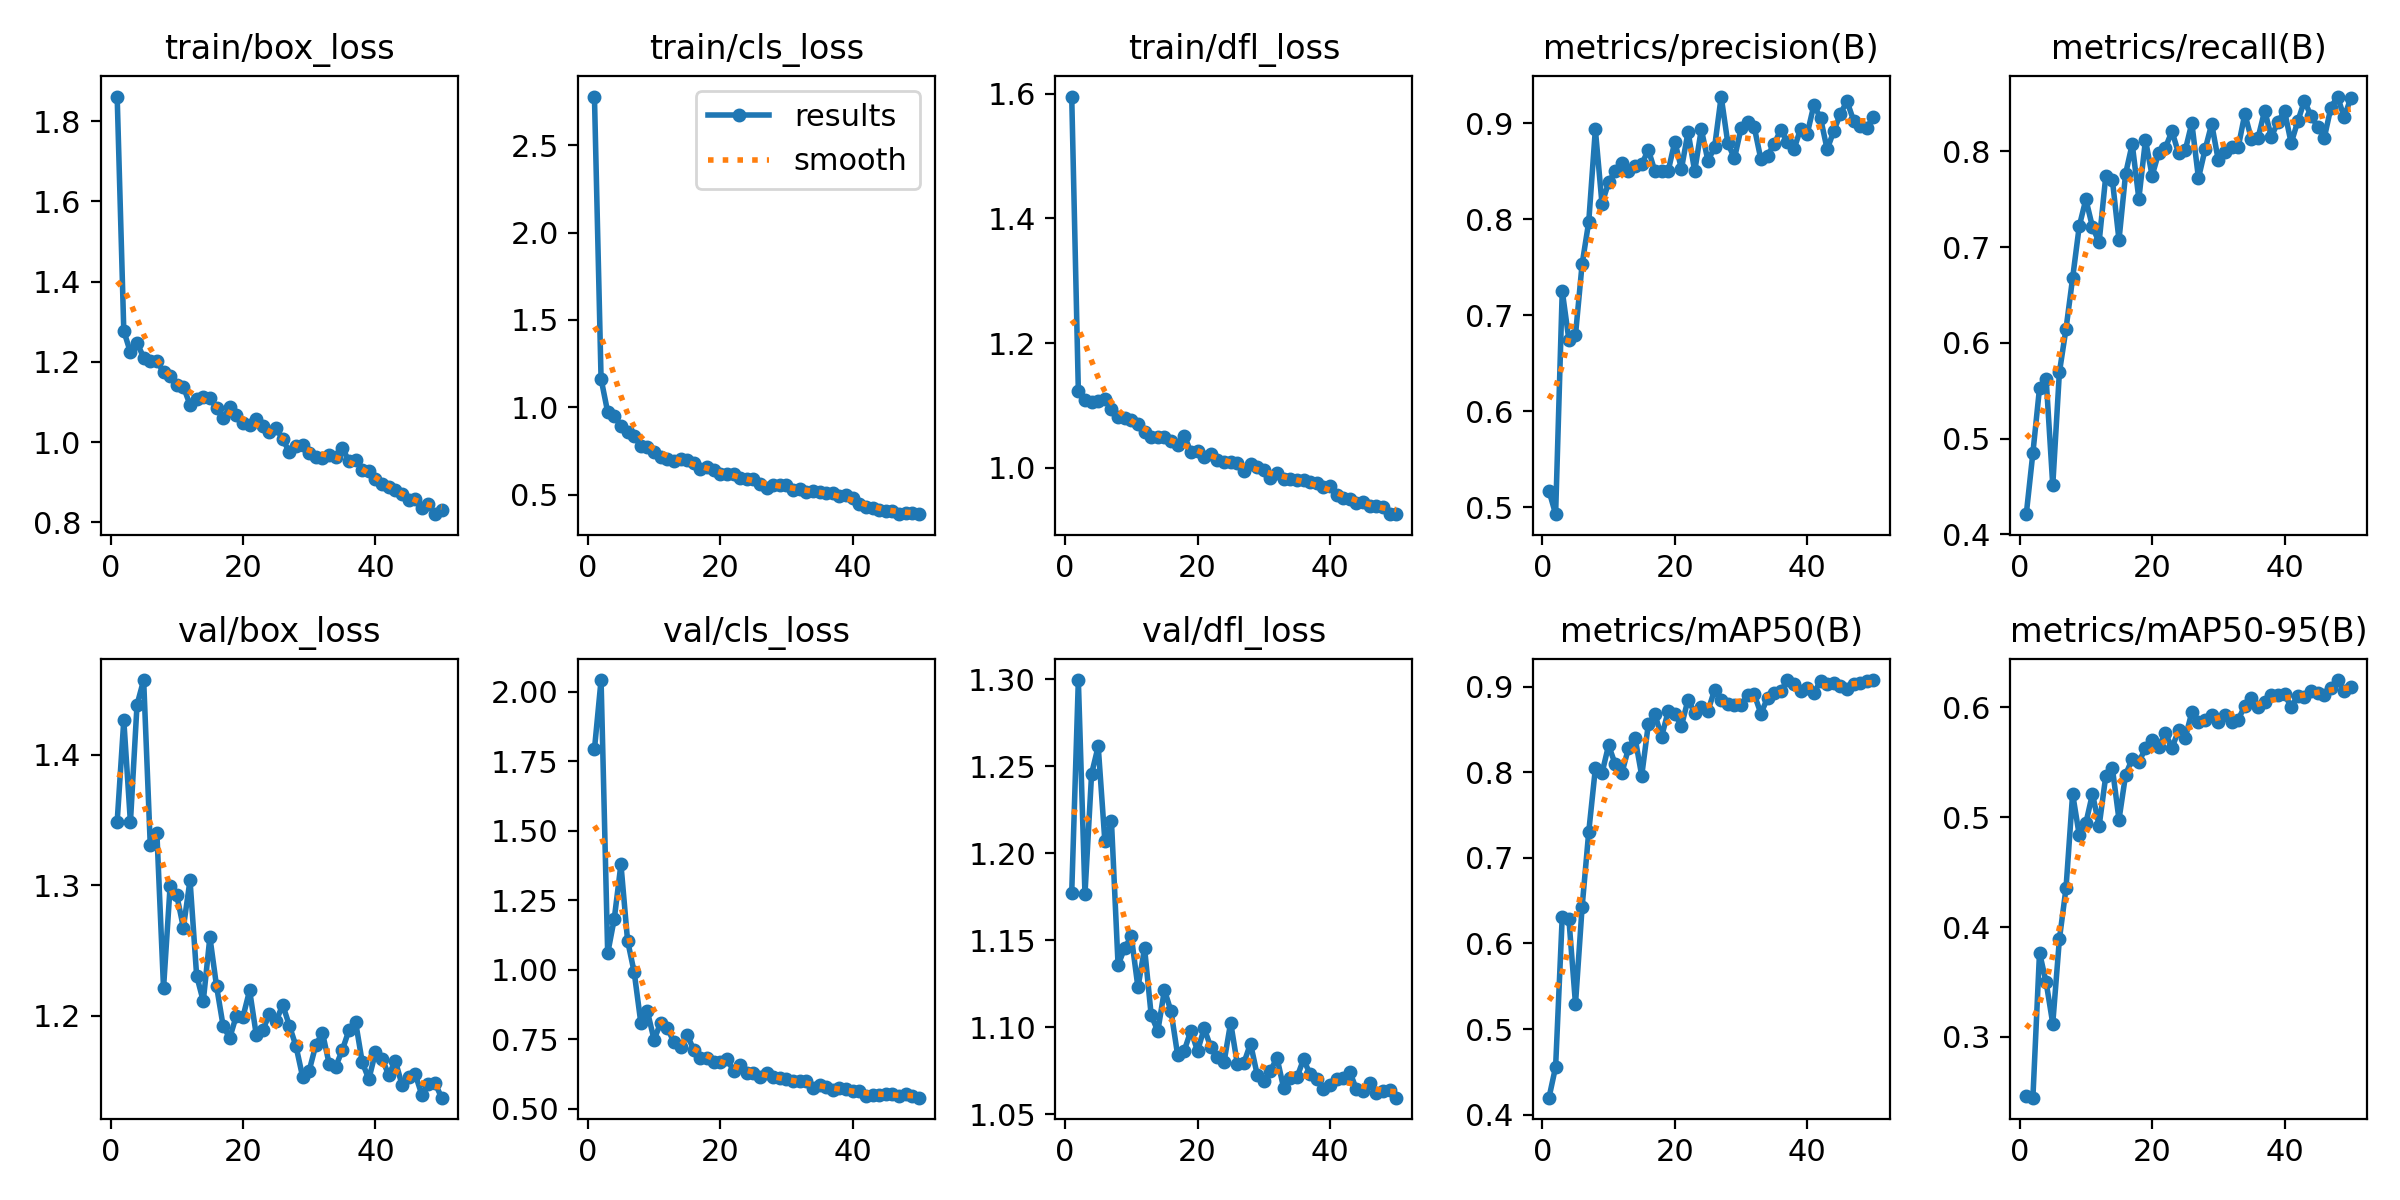

In [91]:
Image(filename= path_to_yolo + path_to_run + 'results.png', width=1000)

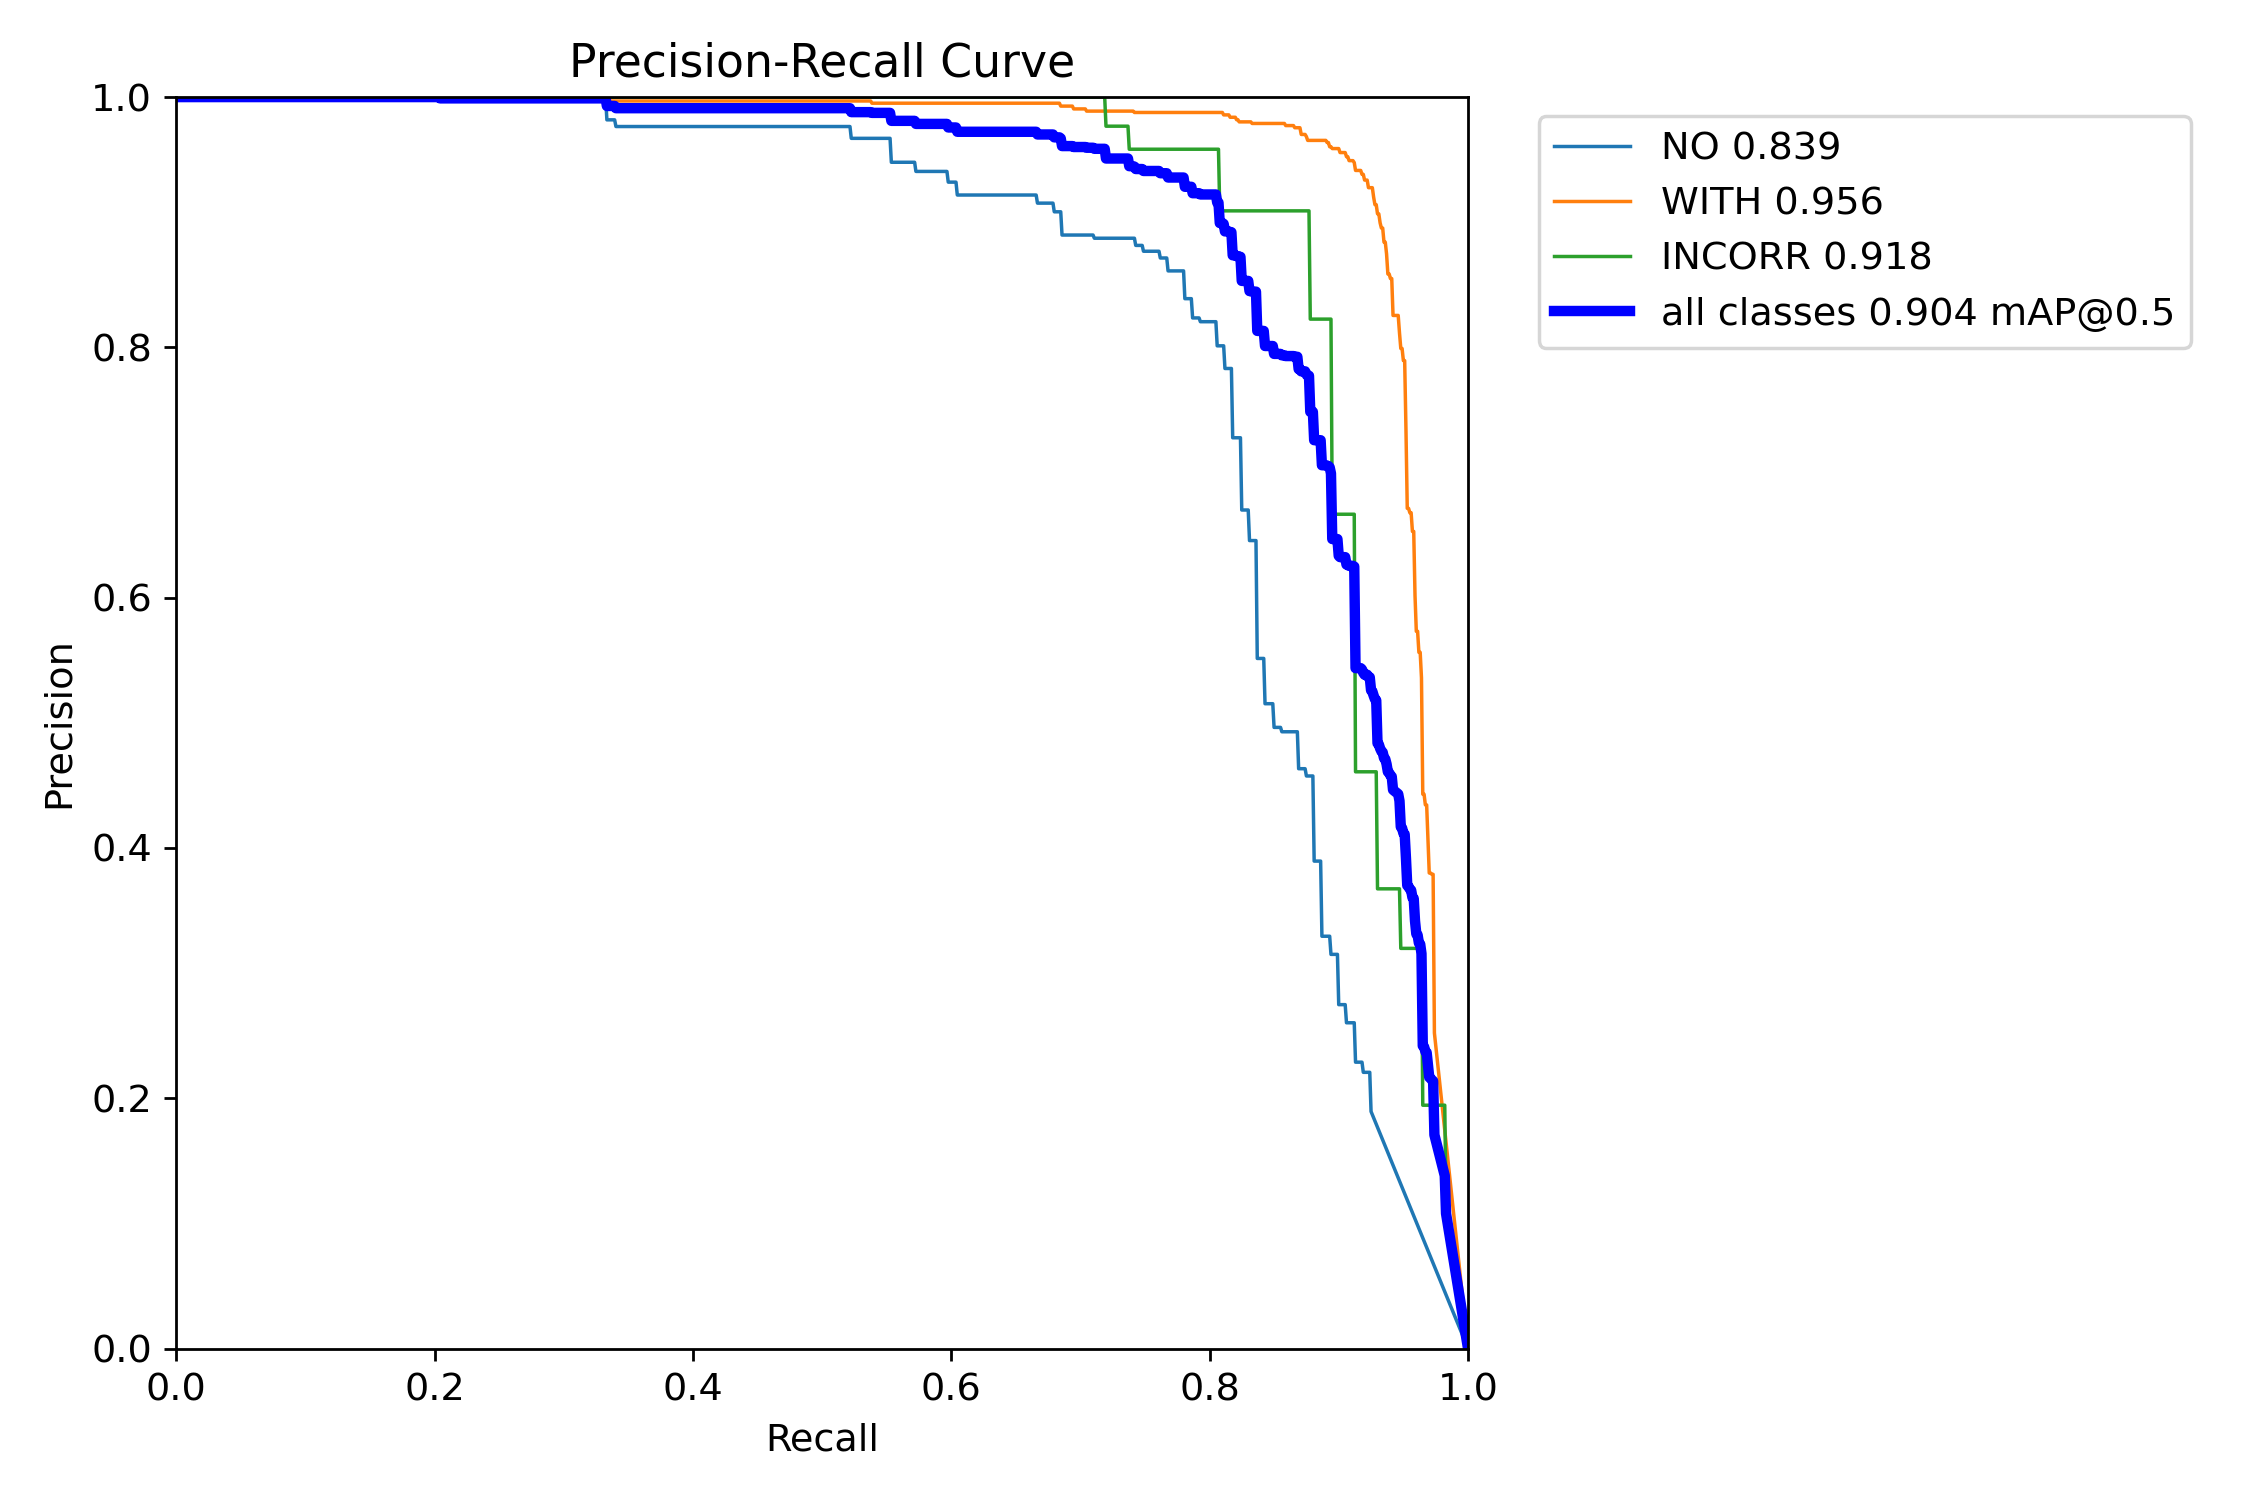

In [92]:
Image(filename=path_to_yolo + path_to_run + 'PR_curve.png', width=700)

In [93]:
#model = YOLO(out_dir + path_to_run + 'weights/best.pt')  # load a pretrained model (recommended for training)

results = yolo.val(data = out_dir + "mask.yaml")  # evaluate model performance on the validation set

Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /home/ss/Documents/ds/git/SF_2/yolov5/data/valid/labels... 191 images, 0 backgrounds, 0 corrupt: 100%|██████████| 191/191 [00:00<00:00, 2168.67it/s]

val: New cache created: /home/ss/Documents/ds/git/SF_2/yolov5/data/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:43<00:00,  3.59s/it]


                   all        191        811      0.897      0.857      0.905      0.626
                    NO         65        159       0.86      0.775      0.839       0.55
                  WITH        153        595      0.937      0.919      0.956      0.669
                INCORR         39         57      0.893      0.877      0.918      0.658
Speed: 1.9ms preprocess, 209.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val


In [94]:
#print("Class indices with average precision:", results.ap_class_index)
#print("Average precision for all classes:", results.box.all_ap)
#print("Average precision:", results.box.ap)
yolov8s_mAP50  = np.mean(results.box.ap50).round(3)
print(f"Average precision at IoU=0.50: {results.box.ap50} \n mAP50: {yolov8s_mAP50}")
#print("Class indices for average precision:", results.box.ap_class_index)
#print("Class-specific results:", results.box.class_result)
#print("F1 score:", results.box.f1)
#print("F1 score curve:", results.box.f1_curve)
#print("Overall fitness score:", results.box.fitness)
#print("Mean average precision:", results.box.map)
#print("Mean average precision at IoU=0.50:", results.box.map50)
#print("Mean average precision at IoU=0.75:", results.box.map75)
#print("Mean average precision for different IoU thresholds:", results.box.maps)
#print("Mean results for different metrics:", results.box.mean_results)
#print("Mean precision:", results.box.mp)
#print("Mean recall:", results.box.mr)
#print("Precision:", results.box.p)
#print("Precision curve:", results.box.p_curve)
#print("Precision values:", results.box.prec_values)
#print("Specific precision metrics:", results.box.px)
#print("Recall:", results.box.r)
#print("Recall curve:", results.box.r_curve)

Average precision at IoU=0.50: [    0.83919     0.95612     0.91833] 
 mAP50: 0.905


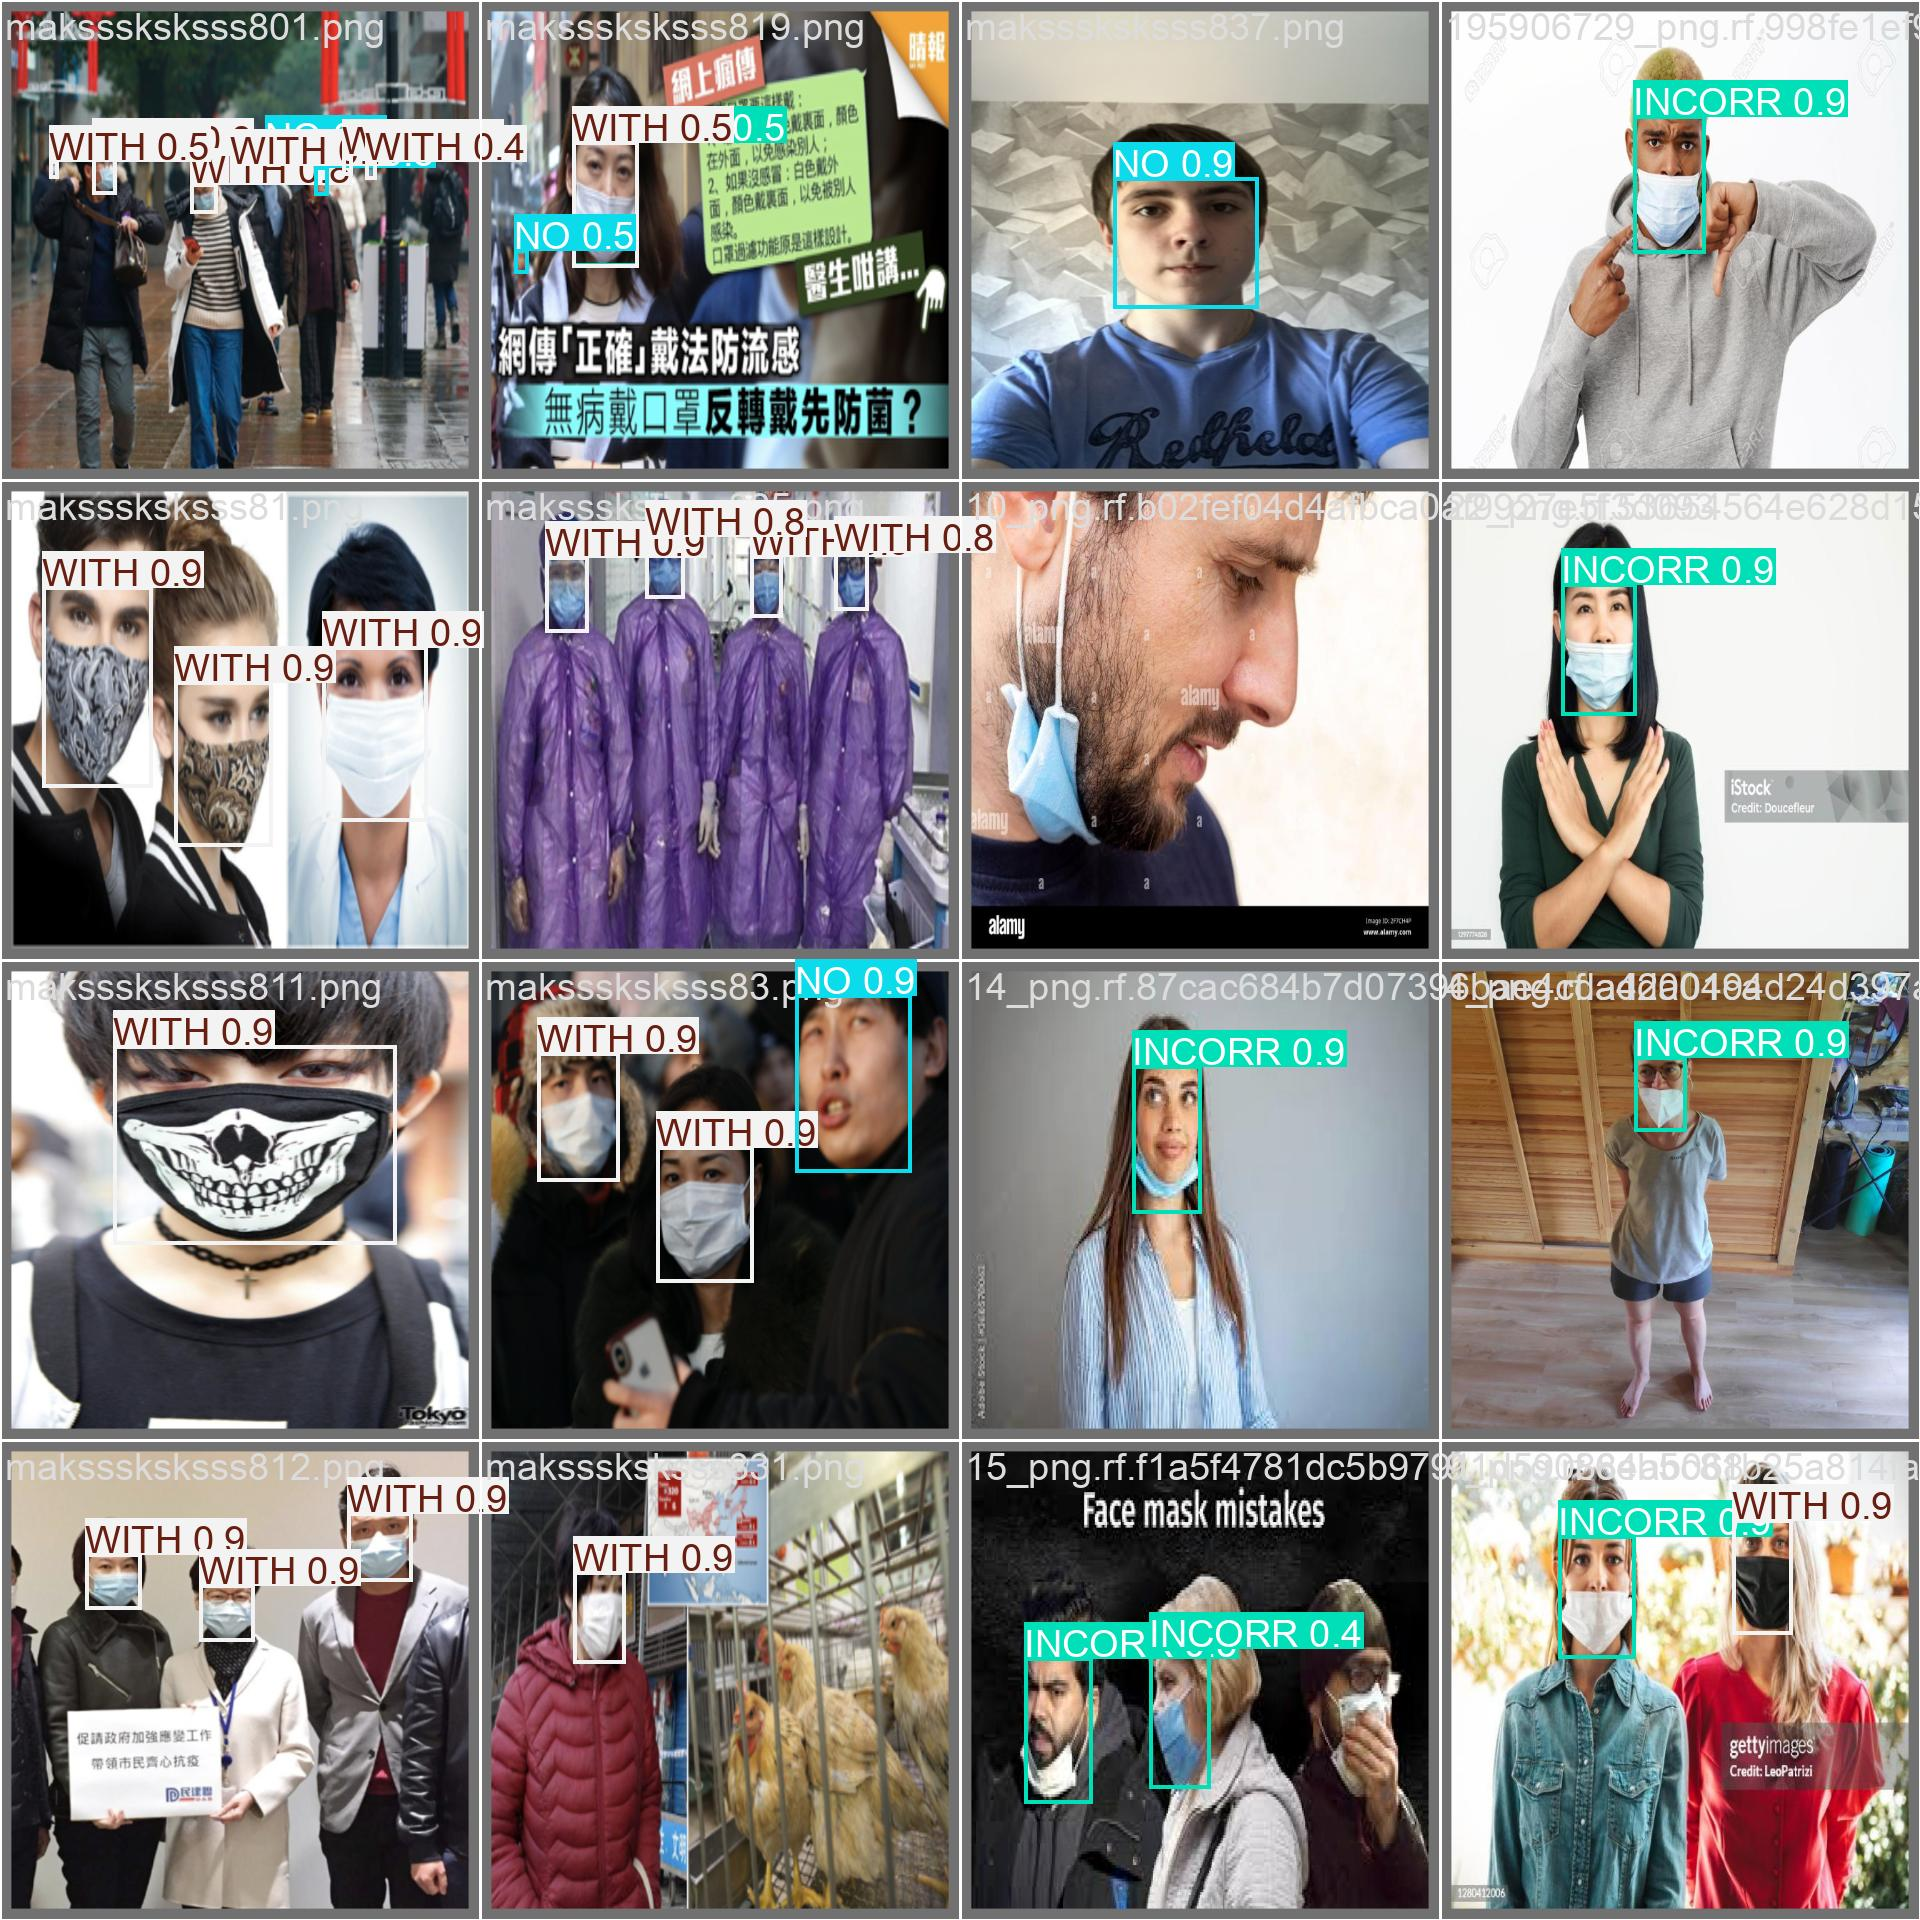

In [95]:
Image(filename=path_to_yolo + path_to_run + '/val_batch0_pred.jpg', width=1200)

In [121]:
# computing mAP from scratch to compare with the score under the hood of YOLO
thresholds = [0.5, 0.75, 0.95] 
df = pd.DataFrame()
res = []

metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5], extended_summary=False, class_metrics=True)
for ims, ans, _ in data_loader_valid:
    ims = list(image.to(device) for image in ims)
    ans = [{k: v.to(device) for k, v in an.items()} for an in ans]

    for t,i in zip(ans, ims):
        p = yolo.predict(torch.stack([i]))
        pred_dict = dict()
        pred_dict['boxes'] = p[0].boxes.xyxy
        pred_dict['scores'] = p[0].boxes.conf
        pred_dict['labels'] = p[0].boxes.cls.to(torch.long)
        metric.update([pred_dict], [t])
        for threshold in thresholds: 
            df = get_score_df(df, t, p, threshold, yolov=8)

metric_res = metric.compute()
metric.reset()
print(metric_res)

yolo8s_AP50_torch = metric_res['map_per_class']
yolo8s_mAP50_torch = metric_res['map'].item()
#print(f'AP50 in classes:{yolo8s_AP50_torch}')
#print(f"mAP50: {round(yolo8s_mAP50_torch,3)}")

print(f"Metric DF shape: {df.shape}")
df.head().style.set_properties(subset=df.columns, **{'width': '50px', 'text-align': 'right'})


0: 640x640 2 WITHs, 399.2ms
Speed: 0.0ms preprocess, 399.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 NOs, 14 WITHs, 1 INCORR, 202.1ms
Speed: 0.0ms preprocess, 202.1ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 WITH, 1 INCORR, 182.9ms
Speed: 0.0ms preprocess, 182.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 NOs, 6 WITHs, 180.8ms
Speed: 0.0ms preprocess, 180.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 WITH, 182.0ms
Speed: 0.0ms preprocess, 182.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 WITH, 172.9ms
Speed: 0.0ms preprocess, 172.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 NOs, 5 WITHs, 188.1ms
Speed: 0.0ms preprocess, 188.1ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 WITH, 180.1ms
Speed: 0.0ms preprocess, 180.1ms inference, 

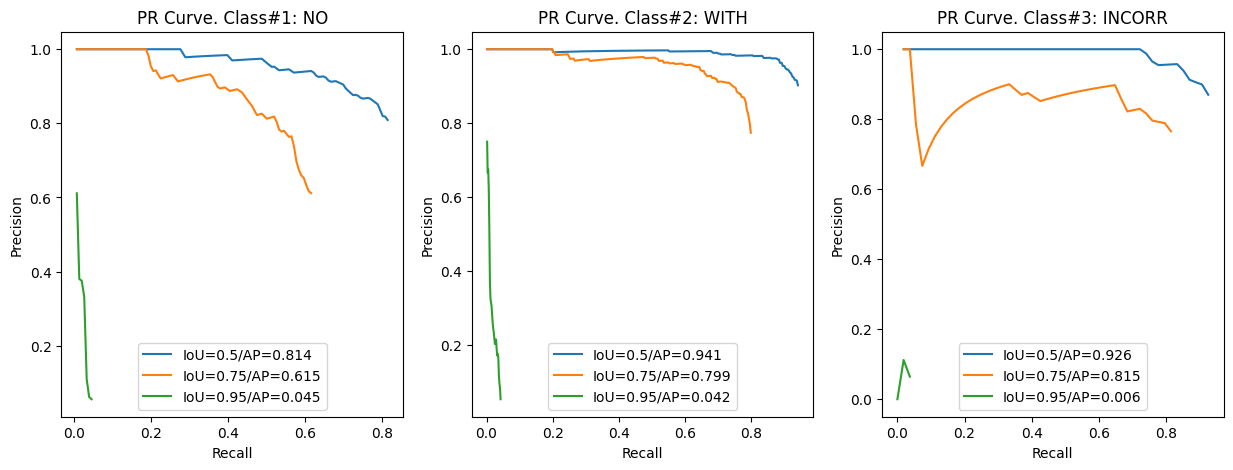

AP50 in classes (from scratch): {1: 0.814, 2: 0.941, 3: 0.926}
mAP50 (from scratch): 0.894


In [122]:
yolo8s_AP50_scratch = get_metrics(df, class_decoder)
yolo8s_mAP50_scratch = np.mean(list(yolo8s_AP50_scratch.values())).round(3)

print(f'AP50 in classes (from scratch): {yolo8s_AP50_scratch}')
print(f"mAP50 (from scratch): {yolo8s_mAP50_scratch}")

In [123]:
print('average IOU in classes:')
display(df.groupby('label')['iou'].mean())
print('MEAN IOU:', df.groupby('label')['iou'].mean().mean().round(2))

average IOU in classes:


label
1    0.592644
2    0.722773
3    0.726434
Name: iou, dtype: float64

MEAN IOU: 0.68


## Summary

In [107]:
# reading json with training duration data
f = open(path_to_project + 'data/import/model_train_time_50eps.json')
train_time = json.load(f)[0]

frcnn_time = round(train_time['train_time_fasterrcnn'],2)/60
yolo8s_time = round(train_time['train_time_yolo8s'],2)/60

In [108]:
# defining model weights file size
frcnn_weight = round(os.stat(path_to_project + 'data/import/' + 'fasterrcnn.pt').st_size / 1000000,2)
yolov8_weight = round(os.stat(path_to_yolo + path_to_run + 'weights/best.pt').st_size / 1000000,2)

In [124]:
summary = pd.DataFrame(
    [
    ['FasterRCNN', round(frcnn_time,2), frcnn_weight, frcnn_mAP50_scratch], 
    ['YoloV8s', round(yolo8s_time,2), yolov8_weight, yolo8s_mAP50_scratch]
    ], 
    columns=['Model', 'train_time, min', 'model_weight, MB', 'mAP50'],
    ).set_index(['Model'])

summary.style.set_properties(subset=summary.columns, **{'width': '130px', 'text-align': 'right'})

    YOLOv8 showed better results over all criteria used:
    * it spends much less time for training (6x advantage)
    * weights file of YOLO 22.5 MB VS 173 MB for FasterRCNN
    * YOLOv8 provides better mAP50 but this metric values for both models are similar and comparable
    Upon the whole, AP per class & mAP50 computed from scratch are comparable to those values provided by YOLO8s    AP per class & mAP50 computed from scratch are comparable to those values provided by YOLO8s   